# <span style="color:Purple">TReNDS  🅽🅴🆁🅾🅸🅼🅰🅶🅸🅽🅶  Visualization, Analysis and Evaluation ✔

## Multiscanner normative age and assessments prediction with brain function, structure, and connectivity.
In this competition, we will predict multiple assessments plus age from multimodal brain MRI features. Due to the complexity of the brain and differences between scanners, generalized approaches will be essential to effectively propel multimodal neuroimaging research forward. 
    
    
    

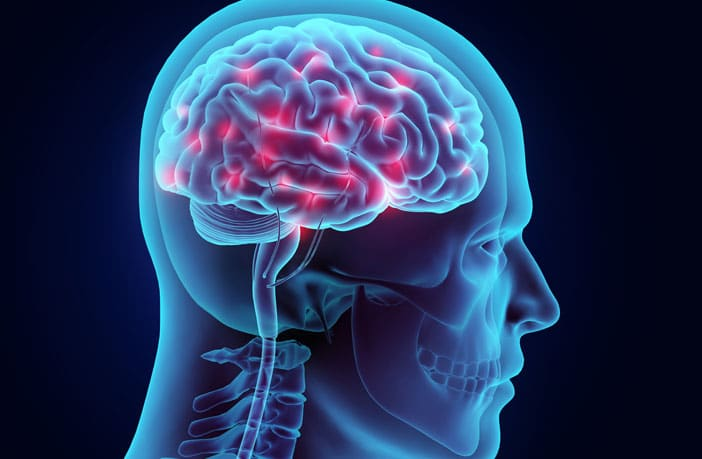

    
**<span style="color:Red">I have just started to working in this project, so it is on progress, I will update time by time**
### Please upvote this kernel if you like it  :-)

# Import Libraries

* **JoyPy** is a one-function Python package based on matplotlib + pandas with a single purpose.
* **Nilearn** is a Python module for fast and easy statistical learning on NeuroImaging data.
It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis.
* **NiBabel** Read / write access to some common neuroimaging file formats.
* **HDF5** lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.


In [ ]:
!pip install joypy --progress-bar off

In [ ]:
import os
import random
import seaborn as sns
import cv2

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL

import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
import h5py
import plotly.graph_objs as go
from IPython.display import Image, display
import joypy
import warnings
warnings.filterwarnings("ignore")

# Check dataset list and type

In [ ]:
os.listdir('/kaggle/input/trends-assessment-prediction/')

# Load Dataset

In [ ]:
BASE_PATH = '../input/trends-assessment-prediction'

train_data_dir = f'{BASE_PATH}/fMRI_train'
test_data_dir = f'{BASE_PATH}/fMRI_test'


In [ ]:
loading_data = pd.read_csv(f'{BASE_PATH}/loading.csv')
train_data = pd.read_csv(f'{BASE_PATH}/train_scores.csv')
sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")


In [ ]:
loading_data.head()

In [ ]:
loading_data.shape

In [ ]:
train_data.head()

In [ ]:
train_data.shape

In [ ]:
total = train_data.isnull().sum()
percent = total/train_data.isnull().count()*100
missing_train_data= pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

# Exploratory Data Analysis

In [ ]:
def plot_bar(df, feature, title='', show_percent = False, size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.barplot(np.round(df[feature].value_counts().index).astype(int), df[feature].value_counts().values, alpha=0.8, palette='Set2')

    plt.title(title)
    if show_percent:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center", rotation=45) 
    plt.xlabel(feature, fontsize=12, )
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plot_bar(train_data, 'age', 'age count and %age plot', show_percent=True, size=3)

from the above plot we can understand Top 5 most frequent ages are 57, 60, 54, 55, 50.

# HeatMap

In [ ]:
temp_data =  train_data.drop(['Id'], axis=1)
plt.figure(figsize = (15, 10))
sns.heatmap(temp_data.corr(), annot = True, cmap="brg")
plt.yticks(rotation=0) 
plt.show()

#### From the above heatmap we can see that Age and domain1_var1 corelated and significant, let's go forward.

## Let's make a heatmap of Loading Data

In [ ]:
temp_data =  loading_data.drop(['Id'], axis=1)

plt.figure(figsize = (20, 20))
sns.heatmap(temp_data.corr(), annot = True, cmap="RdYlGn")
plt.yticks(rotation=0) 

plt.show()

IC_13, IC_14 having high co relation value here !

In [ ]:
temp_data =  loading_data.drop(['Id'], axis=1)
# Create correlation matrix
correl = temp_data.corr().abs()

# Select upper triangle of correlation matrix
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

print('Very high correlated features: ', to_drop)

In [ ]:
import joypy

targets= loading_data.columns[1:]


plt.figure(figsize=(16,10), dpi= 90)
fig, axes = joypy.joyplot(loading_data, column=list(targets), ylim='own', figsize=(14,10))

# Decoration
plt.title('Distribution of features IC_01 to IC_29', fontsize=22)
plt.show()

# Visualization using Nilearn

this portion is inspired by Soham Mukherjee's Kernal, adding the link of his kernal.

https://www.kaggle.com/soham1024/visualization-using-nilearn

In [ ]:
!wget https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii

DPABI is a toolbox for Data Preprocessing and Analysing  Brain Imaging; using ch2bettertemplate to visualize various dimesion, axis, gray matter of brain.

In [ ]:
mask_filename = f'{BASE_PATH}/fMRI_mask.nii'
subject_filename = '../input/trends-assessment-prediction/fMRI_train/10015.mat'
smri_filename = 'ch2better.nii'
mask_niimg = nl.image.load_img(mask_filename)

In [ ]:
def load_subject(filename, mask_niimg):
    subject_data = None
    with h5py.File(subject_filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    return subject_niimg
subject_niimg = load_subject(subject_filename, mask_niimg)
print("Image shape is %s" % (str(subject_niimg.shape)))
num_components = subject_niimg.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))

In [ ]:
nlplt.plot_prob_atlas(subject_niimg, bg_img=smri_filename, view_type='filled_contours', draw_cross=False,title='All %d spatial maps' % num_components, threshold='auto')

# Individual Component Feautures of all 53

In [ ]:
grid_size = int(np.ceil(np.sqrt(num_components)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1
for i, cur_img in enumerate(nl.image.iter_img(subject_niimg)):
    col = i % grid_size
    if col == 0:
        row += 1
    nlplt.plot_stat_map(cur_img, bg_img=smri_filename, title="IC %d" % i, axes=axes[row, col], threshold=3, colorbar=False)
    

In [ ]:
from nilearn import datasets

# haxby dataset to have EPI images and masks
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is at: %s' %
      haxby_dataset.func[0])  # 4D data

haxby_anat_filename = haxby_dataset.anat[0]
haxby_mask_filename = haxby_dataset.mask_vt[0]
haxby_func_filename = haxby_dataset.func[0]

# one motor contrast map from NeuroVault
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]

In [ ]:
from nilearn import plotting

# Visualizing t-map image on EPI template with manual
# positioning of coordinates using cut_coords given as a list
plotting.plot_stat_map(stat_img,
                       threshold=3, title="plot_stat_map",
                       cut_coords=[36, -27, 66])

In [ ]:
plotting.plot_glass_brain(stat_img, title='plot_glass_brain',
                          threshold=3)

# Brain Development Function

In [ ]:
from nilearn import datasets

rest_dataset = datasets.fetch_development_fmri(n_subjects=20)
func_filenames = rest_dataset.func
confounds = rest_dataset.confounds

In [ ]:
# Import dictionary learning algorithm from decomposition module and call the
# object and fit the model to the functional datasets
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=8, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
# Note that this attribute is implemented from version 0.4.1.
# For older versions, see the note section above for details.
components_img = dict_learn.components_img_

# Visualization of functional networks
# Show networks using plotting utilities
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

In [ ]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 8))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)


In [ ]:
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)


title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)

# Submission Part

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold

def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))



In [ ]:
fnc_df.shape

In [ ]:
df = fnc_df.merge(loading_data, on="Id")
df.head()

In [ ]:
train_score = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")
train_score.head()

In [ ]:
train_score["is_train"] = True
df = df.merge(train_score, on="Id", how="left")
df.head()

In [ ]:
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

df.shape, test_df.shape

In [ ]:
fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_data.columns[1:])

# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/500

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [ ]:
%%time
NUM_FOLDS = 7
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)


features = loading_features + fnc_features

overal_score = 0
for target, c, w in [("age", 100, 0.3), ("domain1_var1", 10, 0.175), ("domain1_var2", 10, 0.175), ("domain2_var1", 10, 0.175), ("domain2_var2", 10, 0.175)]:    
    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = SVR(C=c, cache_size=3000.0)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 4))
    print()
    
print("Overal score:", np.round(overal_score, 4))

In [ ]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

In [ ]:
sub_df.to_csv("submission.csv", index=False)

# Work in Progress , kindly Upvote if you like the notebook ❤

### <span style="color:Blue">What you are understanding and what is the possibility regarding Neuroimaging and Neuromorphic Computing, kindly comment below to share your knowledge :-)

**Thanks Again for going through the Kernel ♡**